In [15]:
import pandas as pd
import hashlib
from supabase import create_client, Client
import os
from dotenv import load_dotenv
from itertools import islice
import matplotlib.pyplot as plt



In [16]:
load_dotenv()

SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_KEY")
supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)


In [18]:
df = pd.read_csv("preprocessed_redditData-removedtopic.csv")


In [19]:
print("Script started!", flush=True)
def hash_content(content: str) -> str:
    return hashlib.md5(content.encode('utf-8')).hexdigest()


df["content_hash"] = df["text"].apply(lambda x: hash_content(str(x)) if pd.notna(x) else None)
unique_contents = df[["text", "content_hash"]]
print(f"Unique content rows: {len(unique_contents)}", flush=True)

chunk_size = 500
existing_map = {}

for i in range(0, len(unique_contents), chunk_size):
    chunk = unique_contents.iloc[i:i + chunk_size]
    result = supabase.table("dim_content") \
        .select("id", "content_hash") \
        .in_("content_hash", chunk["content_hash"].tolist()) \
        .execute()
    if result.data:
        existing_map.update({row["content_hash"]: row["id"] for row in result.data})

print(f"Existing content hashes in DB: {len(existing_map)}", flush=True)


missing_rows = unique_contents[~unique_contents["content_hash"].isin(existing_map.keys())]
print(f"Missing content rows to insert: {len(missing_rows)}", flush=True)

if not missing_rows.empty:
    to_insert = [
        {"content": row["text"], "content_hash": row["content_hash"]}
        for _, row in missing_rows.iterrows()
    ]
    for i in range(0, len(to_insert), chunk_size):
        batch = to_insert[i:i+chunk_size]
        inserted = supabase.table("dim_content").insert(batch).execute()
        if inserted.data:
            for row in inserted.data:
                existing_map[row["content_hash"]] = row["id"]


content_id_map = {
    row["text"]: existing_map[row["content_hash"]]
    for _, row in unique_contents.iterrows()
    if row["content_hash"] in existing_map
}
print(f"Total content IDs mapped: {len(content_id_map)}", flush=True)
dim_cache = {}

def get_or_create_id_cached(table, column, value):
    key = f"{table}:{value}"
    if key in dim_cache:
        return dim_cache[key]
    result = supabase.table(table).select("id").eq(column, value).execute()
    if result.data:
        dim_cache[key] = result.data[0]["id"]
        return dim_cache[key]
    else:
        inserted = supabase.table(table).insert({column: value}).execute()
        dim_cache[key] = inserted.data[0]["id"]
        return dim_cache[key]

fact_post_rows = []

for idx, row in df.iterrows():
    try:
        if pd.isna(row["text"]) or not str(row["text"]).strip():
            continue
        subreddit_id = get_or_create_id_cached("dim_subreddit", "name", row["subreddit"])
        content_id = content_id_map.get(row["text"])
        if not content_id:
            continue  # skip if content not mapped
        year_id = get_or_create_id_cached("dim_year", "year", int(row["year"]))
        month_id = get_or_create_id_cached("dim_month", "month", int(row["month"]))
        day = pd.to_datetime(row["created_utc"]).day
        day_id = get_or_create_id_cached("dim_day", "day", day)
        fact_post_rows.append({
            "subreddit_id": subreddit_id,
            "content_id": content_id,
            "year_id": year_id,
            "month_id": month_id,
            "day_id": day_id
        })
    except Exception as e:
        print(f"Skipping row {idx} due to error: {e}", flush=True)

print(f"Total fact_post rows ready: {len(fact_post_rows)}", flush=True)

if fact_post_rows:
    for i in range(0, len(fact_post_rows), chunk_size):
        batch = fact_post_rows[i:i + chunk_size]
        supabase.table("fact_post").insert(batch).execute()
    print(f"Inserted {len(fact_post_rows)} rows into fact_post.", flush=True)
else:
    print("No valid rows to insert.", flush=True)

Script started!
Unique content rows: 63994
Existing content hashes in DB: 63805
Missing content rows to insert: 8


ValueError: Out of range float values are not JSON compliant: nan

In [9]:
all_data = []
batch_size = 1000
start = 0

while True:
    end = start + batch_size - 1
    response = (
        supabase.table("post_summary")
        .select("*")
        .order("content")  
        .range(start, end)
        .execute()
    )

    if not response.data:
        break

    all_data.extend(response.data)
    print(f"Fetched rows {start} to {end}")
    start += len(response.data)  


df_summary = pd.DataFrame(all_data)
df_summary.drop_duplicates(subset=["subreddit", "year", "content"], inplace=True)


df_summary.to_csv("post_summary.csv", index=False)
print(f"Saved {len(df_summary)} unique rows to post_summary.csv")


Fetched rows 0 to 999
Fetched rows 1000 to 1999
Fetched rows 2000 to 2999
Fetched rows 3000 to 3999
Fetched rows 4000 to 4999
Fetched rows 5000 to 5999
Fetched rows 6000 to 6999
Fetched rows 7000 to 7999
Fetched rows 8000 to 8999
Fetched rows 9000 to 9999
Fetched rows 10000 to 10999
Fetched rows 11000 to 11999
Fetched rows 12000 to 12999
Fetched rows 13000 to 13999
Fetched rows 14000 to 14999
Fetched rows 15000 to 15999
Fetched rows 16000 to 16999
Fetched rows 17000 to 17999
Fetched rows 18000 to 18999
Fetched rows 19000 to 19999
Fetched rows 20000 to 20999
Fetched rows 21000 to 21999
Fetched rows 22000 to 22999
Fetched rows 23000 to 23999
Fetched rows 24000 to 24999
Fetched rows 25000 to 25999
Fetched rows 26000 to 26999
Fetched rows 27000 to 27999
Fetched rows 28000 to 28999
Fetched rows 29000 to 29999
Fetched rows 30000 to 30999
Fetched rows 31000 to 31999
Fetched rows 32000 to 32999
Fetched rows 33000 to 33999
Fetched rows 34000 to 34999
Fetched rows 35000 to 35999
Fetched rows 360

In [13]:
group_df = pd.read_csv('post_summary.csv')


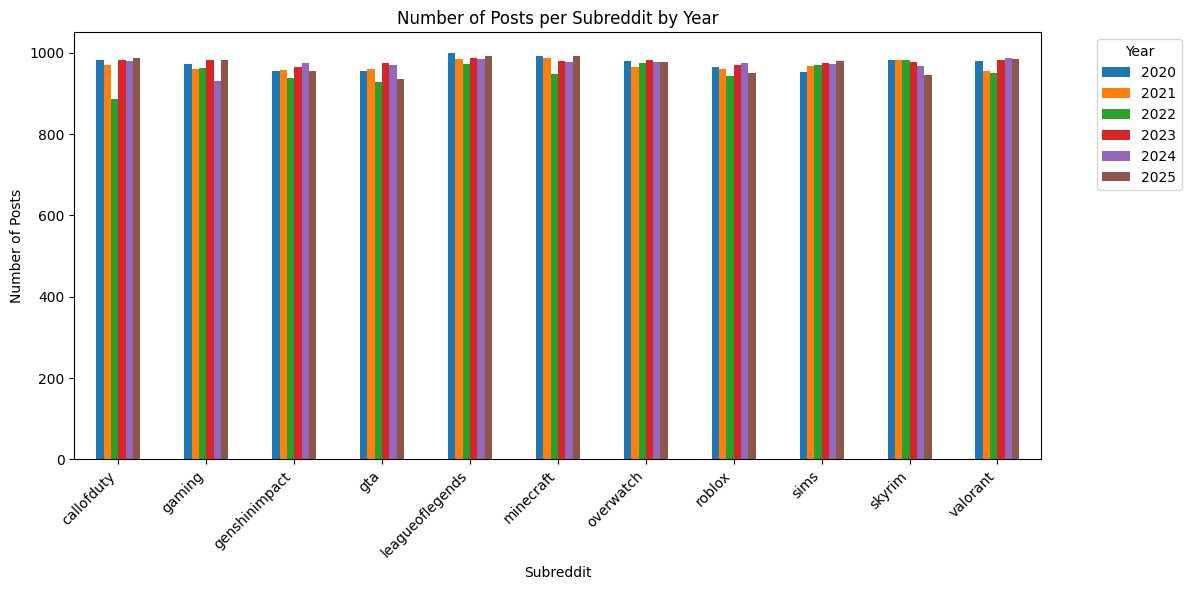

In [14]:
grouped = group_df.groupby(['subreddit', 'year']).size().unstack(fill_value=0)
ax = grouped.plot(kind='bar', figsize=(12, 6))

plt.title('Number of Posts per Subreddit by Year')
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')

plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [12]:
print(grouped)

year             2020  2021  2022  2023  2024  2025
subreddit                                          
callofduty        982   970   887   983   979   988
gaming            973   960   962   981   931   983
genshinimpact     956   958   938   964   974   955
gta               955   959   929   975   969   935
leagueoflegends  1000   985   971   988   984   992
minecraft         991   986   948   979   977   991
overwatch         980   965   974   983   977   976
roblox            965   961   943   970   974   951
sims              953   967   970   975   972   980
skyrim            983   981   982   977   968   946
valorant          979   956   951   982   987   984
